# NX-414 - Mini-project

Group members: Kolly Florian, Mikami Sarah, Montlahuc Louise

## Project description
The objectives of the project are:
- Predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach
- Develop the most accurate model for predicting IT neural activity

Specifically, we use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

## Imports

In [ ]:
# ALL NECESSARY IMPORTS
from abc import ABC
import inspect
import h5py
import os

import gdown
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, SequentialLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import explained_variance_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.calibration import LabelEncoder
from fvcore.common.registry import Registry
from torchvision.models import resnet50, resnext101_32x8d, convnext_base, resnet18, vit_b_16
from torchvision.models import ResNet50_Weights, ResNeXt101_32X8D_Weights, ConvNeXt_Base_Weights, ResNet18_Weights, ViT_B_16_Weights

## Models interface

For genericity and reusability, we define an interface for all models.

In [2]:
# IModel INTERFACE
class IModel(ABC, nn.Module):
    """
    Abstract base class for a model.
    This class defines the interface that all model classes must implement.
    All models inheriting from this class should have a self.model attribute!
    """
    def __init__(self):
        super().__init__()
        self.PCs = dict()
        self.PCA = None
        self.ACTs = dict()

    def forward(self, images):
        return self.model(images)
    
    def get_layers(self):
        """
        Returns the layers on which to do the linear probing.
        """
        layers = []
        layers_name = [name for name, _ in self.model.named_children()]
        for name in layers_name[-4:]:
            module = self.model.get_submodule(name)
            layers.append((name, module))
        return layers
        
    def get_activations(self, hook_name):
        """
        Returns the activations of the model.
        The hook_name can be 'all' for all activations or 'pca' for 1000 principal components.
        """
        if hook_name == 'all':
            return self.ACTs
        elif hook_name == 'pca':
            return self.PCs
        else:
            raise ValueError("Invalid hook name. Use 'all' or 'pca'.")
        
    def reset_activations(self):
        """
        Resets the activations of the model.
        """
        self.PCs = dict()
        self.ACTs = dict()

    def _get_PCs_hook(self, module, input, output, layer_name):
        print('Layer:', layer_name)
        activations = output.detach().cpu().numpy().reshape(output.shape[0], -1)
        print('Activations shape:', activations.shape)
        pca = PCA(n_components=1000)
        print(pca.type())
        self.PCA = pca
        pca_features = pca.fit_transform(activations)
        print('Principal components shape:', pca_features.shape)
        self.PCs[layer_name] = pca_features

    def _get_activations_hook(self, module, input, output, layer_name):
        activations = output.detach().cpu().numpy().reshape(output.shape[0], -1)
        self.ACTs[layer_name] = activations
    
    def register_hook(self, hook_name):
        """
        Registers a hook to the model.
        The hook can be 'all' for all activations or 'pca' for 1000 principal components.
        """
        handles = []
        for name, layer in self.get_layers():
            if hook_name == 'all':
                handle = layer.register_forward_hook(lambda m, i, o, n=name: self._get_activations_hook(m, i, o, n))
            elif hook_name == 'pca':
                handle = layer.register_forward_hook(lambda m, i, o, n=name: self._get_PCs_hook(m, i, o, n))
            handles.append(handle)
        return handles
    
    def change_head(self, layer, num_classes):
        """
        Sets a final head (classification or regression) after the indicated layer.
        """
        return ModifiedModel(self.model, layer, num_classes)

For finetuning models, we create a class that extends our generic model interface ```IModel``` and contains both the original model alongside the modified model. As we are testing multiple models and multiple finetuning methods, our goal is to stay as generic as possible.

In [3]:
# ModifiedModel class
class ModifiedModel(IModel):
    def __init__(self, base_model, insert_after, num_classes):
        super().__init__()
        self.base_model = base_model
        self.insert_after = insert_after
        self.num_classes = num_classes

        # Extract layers up to the insertion point
        self.features = nn.Sequential()
        for name, module in base_model.named_children():
            self.features.add_module(name, module)
            if name == insert_after:
                self.layer = (name, module)
                break

        # TODO testing freezing the layers
        # for param in self.features.parameters():
        #     param.requires_grad = False

        # Determine input dim for new head
        dummy_input = torch.randn(1, 3, 224, 224)
        with torch.no_grad():
            out = self._forward_features(dummy_input)
        out = out.view(out.size(0), -1)
        head_in_features = out.shape[1]

        # Define new head (classification or regression)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(head_in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)
        )

    def _forward_features(self, x):
        for name, module in self.features.named_children():
            if isinstance(module, nn.ModuleList):
                for submodule in module:
                    x = submodule(x)
            else:
                x = module(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = self.fc(x)
        return x
    
    def get_layers(self):
        return self.layer

We then create a build function that takes a model name and a set of parameters, and returns the corresponding model.

In [4]:
MODEL_REGISTRY = Registry("MODEL")
MODEL_REGISTRY.__doc__ = """
Registry for models.

The registered object will be called with `obj()`.
The call should return a `nn.Module` object.
"""

def accepts_seed(cls):
    init = cls.__init__
    sig = inspect.signature(init)
    return 'seed' in sig.parameters

def make_model(name, seed):
    """
    Builds the video model.
    Args:
        name (string): name of the model to build.
    Returns:
        model (nn.Module): the built model.
    """
    model = MODEL_REGISTRY.get(name)
    if accepts_seed(model):
        model = model(seed)
    else:
        model = model()
    
    return model

## Loading the data

Let's now setup the loading of the data. We start with some utility functions that were given in the project.

In [5]:
### Utils
def download_data(path_to_data):
    if not os.path.exists(path_to_data):
        os.makedirs(os.path.dirname(path_to_data))
    output = "IT_data.h5"
    data_path = os.path.join(path_to_data, output)
    if not os.path.exists(data_path):
        url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
        gdown.download(url, os.path.join(path_to_data, output), quiet=False, fuzzy=True)

def load_it_data(path_to_data):
    """ Load IT data

    Args:
        path_to_data (str): Path to the data

    Returns:
        np.array (x6): Stimulus train/val/test; objects list train/val/test; spikes train/val
    """

    datafile = h5py.File(os.path.join(path_to_data,'IT_data.h5'), 'r')

    stimulus_train = datafile['stimulus_train'][()]
    spikes_train = datafile['spikes_train'][()]
    objects_train = datafile['object_train'][()]
    
    stimulus_val = datafile['stimulus_val'][()]
    spikes_val = datafile['spikes_val'][()]
    objects_val = datafile['object_val'][()]
    
    stimulus_test = datafile['stimulus_test'][()]
    objects_test = datafile['object_test'][()]

    ### Decode back object type to latin
    objects_train = [obj_tmp.decode("latin-1") for obj_tmp in objects_train]
    objects_val = [obj_tmp.decode("latin-1") for obj_tmp in objects_val]
    objects_test = [obj_tmp.decode("latin-1") for obj_tmp in objects_test]

    return stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val

Let's now create a function for retrieving the data we are interested in.

In [6]:
def get_data():
    """Get the data from the IT dataset.

    Returns:
        tuple: tuples (stimulus, objects, spikes) for training and validation sets.
    """
    stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data('src/data/')
    return (stimulus_train, objects_train, spikes_train), (stimulus_val, objects_val, spikes_val)

## Part 1: Linear regression models to predict neural activity from pixels

First, we load the dataset using the functions defined above.

In [7]:
train_data, val_data = get_data()
stimulus_train, objects_train, spikes_train = train_data
stimulus_val, objects_val, spikes_val = val_data

In the first part of the project, we develop a linear regression model which can predict the neural activity from pixels. We use three different types of linear regression: least-square regression, ridge regression, and ridge regression with high regularization.

In [ ]:
linreg = LinearRegression()
ridge = Ridge(alpha=1.0)
ridge_highreg = Ridge(alpha=100.0)

# Flatten the images into a 2D array (n_stimulus, n_channels * img_size * img_size)
stim_train = stimulus_train.reshape(stimulus_train.shape[0], -1)

linreg.fit(stim_train, spikes_train)
ridge.fit(stim_train, spikes_train)
ridge_highreg.fit(stim_train, spikes_train)

# Evaluate the models on the training data (R^2 score), if too high can indicate overfitting
linreg_score_train = linreg.score(stim_train, spikes_train)
ridge_score_train = ridge.score(stim_train, spikes_train)
ridge_highreg_score_train = ridge_highreg.score(stim_train, spikes_train)

print('Linear regression score on training data: ', linreg_score_train)
print('Ridge regression score on training data: ', ridge_score_train)
print('Ridge regression score with high regularization on training data: ', ridge_highreg_score_train)

stim_val = stimulus_val.reshape(stimulus_val.shape[0], -1)

# Evaluate the models on the validation data (R^2 score)
linreg_score_val = linreg.score(stim_val, spikes_val)
ridge_score_val = ridge.score(stim_val, spikes_val)
ridge_highreg_score_val = ridge_highreg.score(stim_val, spikes_val)

print('Linear regression score on validation data: ', linreg_score_val)
print('Ridge regression score on validation data: ', ridge_score_val)
print('Ridge regression score with high regularization on validation data: ', ridge_highreg_score_val)

/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=2.92552e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Linear regression score on training data:  0.3549268841743469
Ridge regression score on training data:  0.9999985694885254
Ridge regression score with high regularization on training data:  0.9958826899528503
Linear regression score on validation data:  -0.03741227462887764
Ridge regression score on validation data:  -1.167136549949646
Ridge regression score with high regularization on validation data:  -0.9105490446090698


Now, we can evaluate your prediction by checking both the correlation and explained variance for each neuron. We plot the distribution for the explained variance across neurons.

In [ ]:
def evaluate_model(model, stimulus, spikes):
    pred = model.predict(stimulus.reshape(stimulus.shape[0], -1))

    correlations = []
    explained_variances = []

    for i in range(spikes.shape[1]):
        # Correlation
        corr, _ = pearsonr(pred[:, i], spikes[:, i])
        correlations.append(corr)
        
        # Explained variance
        ev = explained_variance_score(pred[:, i], spikes[:, i])
        explained_variances.append(ev)

    # Plot distribution of explained variance
    plt.hist(explained_variances, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Explained variance')
    plt.ylabel('# neurons')
    plt.title('Distribution of explained variance across neurons')
    plt.show()

evaluate_model(linreg, stimulus_val, spikes_val)

To improve the performance, we applied Principal Component Analysis (PCA) instead of predicting from pixels. This helps capturing the high dimensional structure of the images. We used the corresponding 1000 PCs.

In [ ]:
pca = PCA(n_components=1000)
stim_train_pca = pca.fit_transform(stim_train)
stim_val_pca = pca.transform(stim_val)

linreg = LinearRegression()
ridge = Ridge(alpha=1.0)
ridge_highreg = Ridge(alpha=100.0)

linreg.fit(stim_train_pca, spikes_train)
ridge.fit(stim_train_pca, spikes_train)
ridge_highreg.fit(stim_train_pca, spikes_train)

linreg_score_train = linreg.score(stim_train_pca, spikes_train)
ridge_score_train = ridge.score(stim_train_pca, spikes_train)
ridge_highreg_score_train = ridge_highreg.score(stim_train_pca, spikes_train)

print('Linear regression score on training data: ', linreg_score_train)
print('Ridge regression score on training data: ', ridge_score_train)
print('Ridge (high reg.) regression score on training data: ', ridge_highreg_score_train)

linreg_score_val = linreg.score(stim_val_pca, spikes_val)
ridge_score_val = ridge.score(stim_val_pca, spikes_val)
ridge_highreg_score_val = ridge_highreg.score(stim_val_pca, spikes_val)

print('Linear regression score on validation data: ', linreg_score_val)
print('Ridge regression score on validation data: ', ridge_score_val)
print('Ridge (high reg.) regression score on validation data: ', ridge_highreg_score_val)

Linear regression score on training data:  0.4664270281791687
Ridge regression score on training data:  0.46642693877220154
Ridge (high reg.) regression score on training data:  0.46642249822616577
Linear regression score on validation data:  -0.08039271831512451
Ridge regression score on validation data:  -0.08037959039211273
Ridge (high reg.) regression score on validation data:  -0.07916062325239182


To improve the predictions, we then use a 5-fold cross-validation to find the best parameters for ridge regression between 20 different alpha values. 

In [ ]:
alphas = np.logspace(2, 10, 20)
ridge = Ridge()

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=1)
splits = list(cv.split(stim_train, objects_train, groups=objects_train))
grid_search = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=splits, n_jobs=-1)
grid_search.fit(stim_train, spikes_train)

best_alpha = grid_search.best_params_['alpha']
print("Best alpha value:", best_alpha)

best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(stim_train, spikes_train)
ridge_score_train = best_ridge.score(stim_train, spikes_train)
ridge_score_val = best_ridge.score(stim_val, spikes_val)

print("Best Ridge Regression score on training set:", ridge_score_train)
print("Best Ridge Regression score on validation set:", ridge_score_val)

Best alpha value: 615848.2110660254
Best Ridge Regression score on training set: 0.16825632750988007
Best Ridge Regression score on validation set: 0.08738022297620773


## Part 2: Predict the neural activity with the task-driven modeling approach

One way to improve the predictions is too use the linear regression models we implemented on the activations of each layer of a network like ResNet50. In this part, we use task-driven modeling to predict neural activity. This involves training the network to perform a relevant behavioral task in order to better align its predictions with the brain.

#### 2.1: With stimuli as input, we get activations from the model and we save only the 1000 first PCs for each layer

In [13]:
pretrained_resnet = resnet50(pretrained=True)
pretrained_resnet.eval()

layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

PCs = {'pretrained': dict(), 'untrained': dict()}

def get_PCs_hook(module, input, output, layer_name, model):
    print('Layer:', layer_name)
    activations = output.detach().cpu().numpy().reshape(output.shape[0], -1)
    print('Activations shape:', activations.shape)
    pca = PCA(n_components=1000)
    pca_features = pca.fit_transform(activations)
    print('Principal components shape:', pca_features.shape)
    PCs[model][layer_name] = pca_features

for name, layer in pretrained_resnet.named_children():
    if name in layers:
        layer.register_forward_hook(lambda m, i, o, name=name: get_PCs_hook(m, i, o, name, 'pretrained'))

imgs = stimulus_train
imgs = torch.from_numpy(imgs)
with torch.no_grad():
    pretrained_resnet(imgs)

/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer: conv1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer2
Activations shape: (2592, 401408)
Principal components shape: (2592, 1000)
Layer: layer3
Activations shape: (2592, 200704)
Principal components shape: (2592, 1000)
Layer: layer4
Activations shape: (2592, 100352)
Principal components shape: (2592, 1000)
Layer: avgpool
Activations shape: (2592, 2048)
Principal components shape: (2592, 1000)


#### 2.2: We use PCs to predict neural activity using linear regression

In [32]:
def get_activity_by_layer(layer, model):
    pcs = PCs[model][layer]
    linreg = LinearRegression()

    linreg.fit(pcs, spikes_train)

    # Evaluate the models on the training data (R^2 score), if too high can indicate overfitting
    linreg_score_train = linreg.score(pcs, spikes_train)
    print("For", layer, "of", model, "model - linear regression score on training data: ", linreg_score_train)

    linreg_pred_activity = linreg.predict(pcs)
    return linreg_pred_activity

#### 2.3: We compute and plot the goodness of fit and the explained variance per layer

In [33]:
for layer in layers:
    pred_activity = get_activity_by_layer(layer, 'pretrained')
    correlations = []
    explained_variances = []

    for i in range(spikes_train.shape[1]):
        # Correlation
        corr, _ = pearsonr(pred_activity[:, i], spikes_train[:, i])
        correlations.append(corr)
        
        # Explained variance
        ev = explained_variance_score(pred_activity[:, i], spikes_train[:, i])
        explained_variances.append(ev)

    # TODO: plot de Sarah
    # # Plot distribution of explained variance
    # plt.hist(explained_variances, bins=20, edgecolor='k', alpha=0.7)
    # plt.xlabel('Explained variance')
    # plt.ylabel('# neurons')
    # plt.title('Distribution of explained variance across neurons for layer {}'.format(layer))
    # plt.show()

For conv1 of pretrained model - linear regression score on training data:  0.46412768959999084
For layer1 of pretrained model - linear regression score on training data:  0.6059292554855347
For layer2 of pretrained model - linear regression score on training data:  0.6387455463409424
For layer3 of pretrained model - linear regression score on training data:  0.6879435777664185
For layer4 of pretrained model - linear regression score on training data:  0.665534257888794
For avgpool of pretrained model - linear regression score on training data:  0.6303601861000061


#### 2.4: Finally, we comparing the previous results with using an untrained network

/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/nx-414/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer: conv1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer1
Activations shape: (2592, 802816)
Principal components shape: (2592, 1000)
Layer: layer2
Activations shape: (2592, 401408)
Principal components shape: (2592, 1000)
Layer: layer3
Activations shape: (2592, 200704)
Principal components shape: (2592, 1000)
Layer: layer4
Activations shape: (2592, 100352)
Principal components shape: (2592, 1000)
Layer: avgpool
Activations shape: (2592, 2048)
Principal components shape: (2592, 1000)
For conv1 of untrained model:
Linear regression score on training data:  0.46235620975494385
Ridge regression score on training data:  0.462356299161911
Ridge regression score with high regularization on training data:  0.46232154965400696



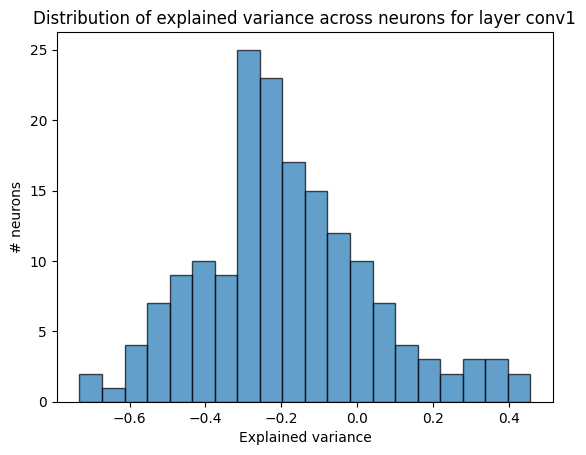

For layer1 of untrained model:
Linear regression score on training data:  0.5580912828445435
Ridge regression score on training data:  0.5580912828445435
Ridge regression score with high regularization on training data:  0.5580576658248901



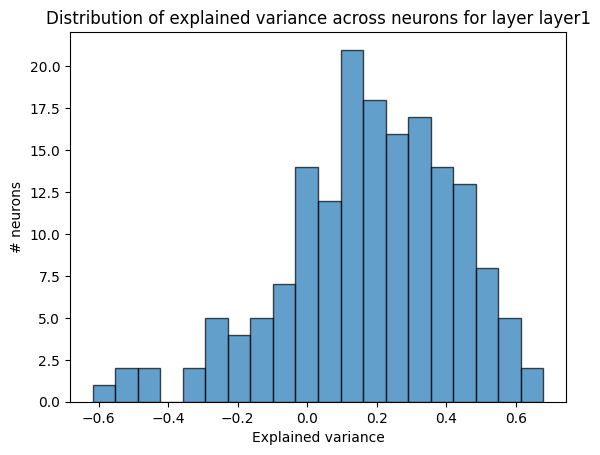

For layer2 of untrained model:
Linear regression score on training data:  0.5583605766296387
Ridge regression score on training data:  0.5583605766296387
Ridge regression score with high regularization on training data:  0.5583564043045044



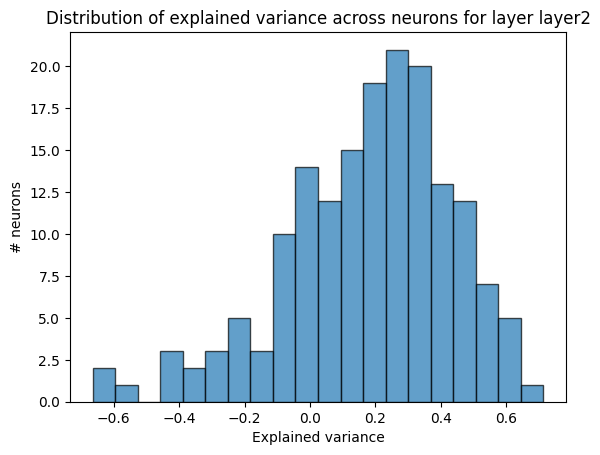

For layer3 of untrained model:
Linear regression score on training data:  0.5531697869300842
Ridge regression score on training data:  0.5531697273254395
Ridge regression score with high regularization on training data:  0.5531697869300842



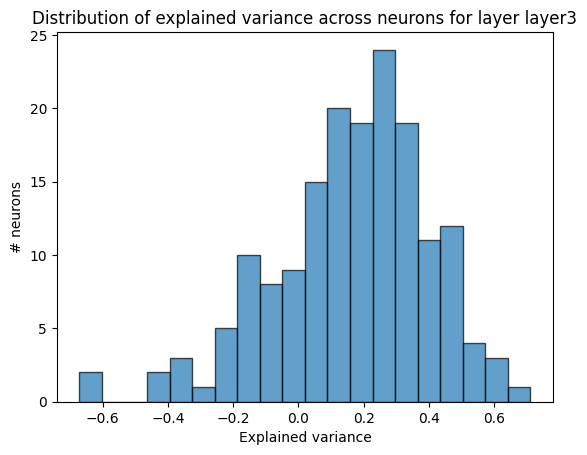

For layer4 of untrained model:
Linear regression score on training data:  0.5419514179229736
Ridge regression score on training data:  0.5419512987136841
Ridge regression score with high regularization on training data:  0.5419514179229736



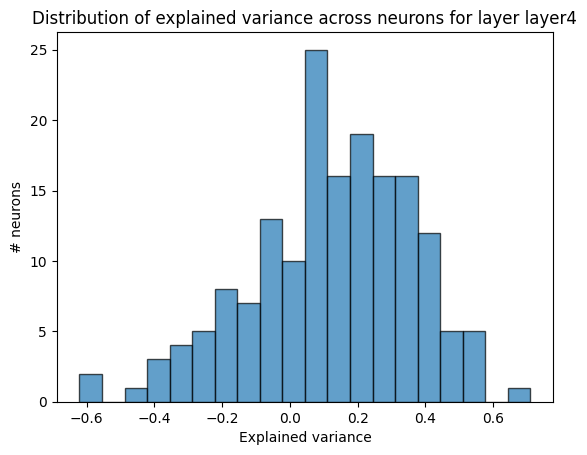

For avgpool of untrained model:
Linear regression score on training data:  0.5240779519081116
Ridge regression score on training data:  0.5240086317062378
Ridge regression score with high regularization on training data:  0.4448855221271515



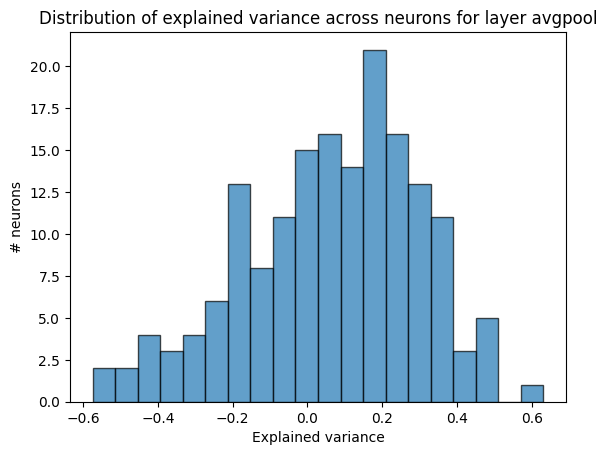

In [23]:
untrained_resnet = resnet50(pretrained=False)
untrained_resnet.eval()

for name, layer in untrained_resnet.named_children():
    if name in layers:
        layer.register_forward_hook(lambda m, i, o, name=name: get_PCs_hook(m, i, o, name, 'untrained'))

imgs = stimulus_train
imgs = torch.from_numpy(imgs)
with torch.no_grad():
    untrained_resnet(imgs)

for layer in layers:
    pred_activity = get_activity_by_layer(layer, 'untrained')
    correlations = []
    explained_variances = []

    for i in range(spikes_train.shape[1]):
        # Correlation
        corr, _ = pearsonr(pred_activity[:, i], spikes_train[:, i])
        correlations.append(corr)
        
        # Explained variance
        ev = explained_variance_score(pred_activity[:, i], spikes_train[:, i])
        explained_variances.append(ev)

    # Plot distribution of explained variance
    plt.hist(explained_variances, bins=20, edgecolor='k', alpha=0.7)
    plt.xlabel('Explained variance')
    plt.ylabel('# neurons')
    plt.title('Distribution of explained variance across neurons for layer {}'.format(layer))
    plt.show()

## Part 3: Predict the neural activity with the data-driven modeling approach

In [34]:
# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

n_out = 168
batch_size = 16
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
if not 'cuda' in device:
    print('Using CPU')

train_dataset = TensorDataset(
    torch.from_numpy(stimulus_train).float(),
    torch.from_numpy(spikes_train).float()
)

val_dataset = TensorDataset(
    torch.from_numpy(stimulus_val).float(),
    torch.from_numpy(spikes_val).float()
)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

def create_setup(optim, use_batch_norm=True):
    img_size = stimulus_train.shape[2]
    
    layers = [
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(128 * (img_size // 4) * (img_size // 4), n_out)
    ]
    if use_batch_norm:
        layers.insert(2, nn.BatchNorm2d(64))
        layers.insert(6, nn.BatchNorm2d(128))

    model = nn.Sequential(*layers)
    model = model.to(device)
    print(model)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) if optim == 'adamw' \
        else torch.optim.SGD(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    return model, optimizer, criterion

def do_train(model, dataloader, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        loss = 0.0
        mae = 0.0
        for data, targets in tqdm(dataloader, desc=f'Training - epoch {epoch+1}'):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, targets)
            loss.backward()
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            loss += loss.item()
            mae += torch.mean(torch.abs(out - targets)).item()

        loss /= len(dataloader)
        mae /= len(dataloader)
        print('Epoch [{}/{}] MSE: {:.4f}, MAE: {:.2f}'.format(epoch+1, epochs, loss, mae))
    
def do_test(model, dataloader, criterion):
    model.eval()
    loss = 0.0
    mae = 0.0
    with torch.no_grad():
        for data, targets in tqdm(dataloader, desc=f'Testing'):
            data, targets = data.to(device), targets.to(device)
            out = model(data)
            loss = criterion(out, targets)

            loss += loss.item()
            mae += torch.mean(torch.abs(out - targets)).item()

        loss /= len(dataloader)
        mae /= len(dataloader)

    return loss, mae

Using CPU


In [ ]:
for optim in ['adamw', 'sgd']:
    for use_batch_norm in [True, False]:
        print(f'Optimizer: {optim}, Batch Norm: {use_batch_norm}')
        model, optimizer, criterion = create_setup(optim, use_batch_norm=use_batch_norm)
        do_train(model, trainloader, optimizer, criterion, 10)
        loss, acc = do_test(model, valloader, criterion)
        print('Final MSE: {:.4f}, MAE: {:.2f}'.format(loss, acc))
        print('--' * 20)

Optimizer: adamw, Batch Norm: True
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [01:47<00:00,  1.51it/s]


Epoch [1/10] MSE: 13.6076, MAE: 22.65


Training - epoch 2: 100%|██████████| 162/162 [01:47<00:00,  1.51it/s]


Epoch [2/10] MSE: 8.3811, MAE: 19.51


Training - epoch 3: 100%|██████████| 162/162 [01:46<00:00,  1.53it/s]


Epoch [3/10] MSE: 3.5580, MAE: 15.40


Training - epoch 4: 100%|██████████| 162/162 [01:44<00:00,  1.55it/s]


Epoch [4/10] MSE: 1.2388, MAE: 10.73


Training - epoch 5: 100%|██████████| 162/162 [01:46<00:00,  1.52it/s]


Epoch [5/10] MSE: 0.2242, MAE: 5.97


Training - epoch 6: 100%|██████████| 162/162 [01:46<00:00,  1.52it/s]


Epoch [6/10] MSE: 0.0021, MAE: 1.36


Training - epoch 7: 100%|██████████| 162/162 [01:47<00:00,  1.50it/s]


Epoch [7/10] MSE: 0.0015, MAE: 0.26


Training - epoch 8: 100%|██████████| 162/162 [01:44<00:00,  1.54it/s]


Epoch [8/10] MSE: 0.0011, MAE: 0.25


Training - epoch 9: 100%|██████████| 162/162 [01:44<00:00,  1.55it/s]


Epoch [9/10] MSE: 0.0012, MAE: 0.24


Training - epoch 10: 100%|██████████| 162/162 [01:42<00:00,  1.59it/s]


Epoch [10/10] MSE: 0.0012, MAE: 0.23


Testing: 100%|██████████| 18/18 [00:03<00:00,  4.67it/s]


Final MSE: 0.0103, MAE: 0.24
----------------------------------------
Optimizer: adamw, Batch Norm: False
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [01:33<00:00,  1.73it/s]


Epoch [1/10] MSE: 0.0018, MAE: 0.40


Training - epoch 2: 100%|██████████| 162/162 [01:37<00:00,  1.67it/s]


Epoch [2/10] MSE: 0.0016, MAE: 0.27


Training - epoch 3: 100%|██████████| 162/162 [01:37<00:00,  1.65it/s]


Epoch [3/10] MSE: 0.0018, MAE: 0.27


Training - epoch 4: 100%|██████████| 162/162 [01:37<00:00,  1.66it/s]


Epoch [4/10] MSE: 0.0016, MAE: 0.27


Training - epoch 5: 100%|██████████| 162/162 [01:39<00:00,  1.63it/s]


Epoch [5/10] MSE: 0.0015, MAE: 0.27


Training - epoch 6: 100%|██████████| 162/162 [01:37<00:00,  1.66it/s]


Epoch [6/10] MSE: 0.0017, MAE: 0.27


Training - epoch 7: 100%|██████████| 162/162 [01:37<00:00,  1.66it/s]


Epoch [7/10] MSE: 0.0019, MAE: 0.27


Training - epoch 8: 100%|██████████| 162/162 [01:35<00:00,  1.70it/s]


Epoch [8/10] MSE: 0.0015, MAE: 0.27


Training - epoch 9: 100%|██████████| 162/162 [01:37<00:00,  1.66it/s]


Epoch [9/10] MSE: 0.0016, MAE: 0.27


Training - epoch 10: 100%|██████████| 162/162 [01:35<00:00,  1.69it/s]


Epoch [10/10] MSE: 0.0019, MAE: 0.27


Testing: 100%|██████████| 18/18 [00:03<00:00,  5.12it/s]


Final MSE: 0.0146, MAE: 0.28
----------------------------------------
Optimizer: sgd, Batch Norm: True
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=401408, out_features=168, bias=True)
)


Training - epoch 1: 100%|██████████| 162/162 [01:35<00:00,  1.70it/s]


Epoch [1/10] MSE: 0.0141, MAE: 0.84


Training - epoch 2: 100%|██████████| 162/162 [13:54<00:00,  5.15s/it]


Epoch [2/10] MSE: 0.0127, MAE: 0.81


Training - epoch 3: 100%|██████████| 162/162 [25:02<00:00,  9.27s/it]  


Epoch [3/10] MSE: 0.0126, MAE: 0.79


Training - epoch 4: 100%|██████████| 162/162 [01:37<00:00,  1.65it/s]


Epoch [4/10] MSE: 0.0127, MAE: 0.78


Training - epoch 5: 100%|██████████| 162/162 [01:38<00:00,  1.64it/s]


Epoch [5/10] MSE: 0.0120, MAE: 0.77


Training - epoch 6:  28%|██▊       | 45/162 [00:26<01:08,  1.70it/s]

## Part 4: Develop the most accurate model for predicting IT neural activity

In this part, our goal is to find the best model for predicting neural activity. We explore both the data-driven and the task-driven approaches and tried the following pretrained models:
- ResNet18
- ResNet50
- ResNeXt
- Vision Transformer (ViT)
- ConvNeXt
- DinoV2

These choices are inspired by the brain-score platform, where they show the highest correlation with the neural activity. The first four are more traditional models that have been widely used in the field of computer vision.

In [ ]:
MODEL_REGISTRY = Registry("MODEL")
MODEL_REGISTRY.__doc__ = """
Registry for models.

The registered object will be called with `obj()`.
The call should return a `nn.Module` object.
"""

def accepts_seed(cls):
    init = cls.__init__
    sig = inspect.signature(init)
    return 'seed' in sig.parameters

def make_model(name, seed):
    """
    Builds the video model.
    Args:
        name (string): name of the model to build.
    Returns:
        model (nn.Module): the built model.
    """
    model = MODEL_REGISTRY.get(name)
    if accepts_seed(model):
        model = model(seed)
    else:
        model = model()
    
    return model

In [ ]:
@MODEL_REGISTRY.register()
class ConvNeXt(IModel):
    def __init__(self):
        super(ConvNeXt, self).__init__()
        self.model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)
    
    def get_layers(self, driven):
        """
        Returns the layers on which to do the linear probing.
        """    
        layer7 = self.model.get_submodule("features.7")
        classif = self.model.get_submodule("classifier")
        return [('layer7', layer7), ('classifier', classif)]

In [ ]:
@MODEL_REGISTRY.register()
class DinoV2(IModel):
    def __init__(self):
        super(DinoV2, self).__init__()
        self.model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
    
    def get_layers(self, driven):
        """
        Returns the layers on which to do the linear probing.
        """
        module_block11 = self.model.get_submodule("blocks.11")
        module_norm = self.model.get_submodule("norm")
        return [('block11', module_block11), ('norm', module_norm)]

In [ ]:
@MODEL_REGISTRY.register()
class ResNet18(IModel):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [ ]:
@MODEL_REGISTRY.register()
class ResNet50(IModel):
    def __init__(self):
        super(ResNet50, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [ ]:
@MODEL_REGISTRY.register()
class ResNeXt(IModel):
    def __init__(self):
        super(ResNeXt, self).__init__()
        self.model = resnext101_32x8d(weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1)

In [ ]:
@MODEL_REGISTRY.register()
class ViT(IModel):
    def __init__(self):
        super(ViT, self).__init__()
        self.model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

### ⚠️ **DISCLAIMER:** </br>
This final part of the project was organised into separate python scripts. For the final submission we tried to merge everything on this notebook. </br>
You do not need to run this code, we are just presenting our work. Go to the end of the notebook to load the best model.

## Loading the best model

Our best $R^2$ score was obtained by finetuning in a data-driven way a pretrained ResNeXt model.

In [ ]:
@MODEL_REGISTRY.register()
class ResNeXt(IModel):
    def __init__(self):
        super(ResNeXt, self).__init__()
        self.model = resnext101_32x8d(weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1)

base_model = make_model('ResNeXt', 0)
model = base_model.change_head('layer4', 168)

We can now load our saved weights:

In [ ]:
weights = torch.load('best_model.pt')
model.load_state_dict(weights)

## Inference time!

Let's try our model on the validation data and check the $R^2$ score we obtain.

In [ ]:
train_data, val_data = get_data()
out = model(val_data[0])